In [14]:
import torch

def vec_find_intervals(t: torch.tensor, x: torch.tensor, k: int):
    n = t.shape[0] - k - 1
    tb = t[k]
    te = t[n]

    result = torch.zeros_like(x, dtype=int)

    nan_indices = torch.isnan(x)
    result[nan_indices] = -1

    out_of_bounds_indices = torch.logical_or(x < tb, x > te)
    result[out_of_bounds_indices] = -1

    l = torch.full_like(x, k, dtype=int)
    while torch.any(torch.logical_and(x < t[l], l != k)):
        l = torch.where(torch.logical_and(x < t[l], l != k), l - 1, l)

    l = torch.where(l != n, l + 1, l)

    while torch.any(torch.logical_and(x >= t[l], l != n)):
        l = torch.where(torch.logical_and(x >= t[l], l != n), l + 1, l)

    result = torch.where(result != -1, l - 1, result)

    return result

In [15]:
import torch

def vectorized_deboor(t, x, k, interval, result):
    
    hh = result[:, k+1:]
    h = result
    result[:, 0] = 1.
        
    for j in range(1, k + 1):
        hh[:, :j] = h[:, :j]
        h[:, 0] = 0
        for n in range(1, j + 1):
            ind = interval + n
            xb = t[ind]
            xa = t[ind - j]
            zero_mask = xa == xb
            
            h[zero_mask, n] = 1.
            w = hh[:, n - 1] / (xb - xa)
            h[:, n - 1] += w * (xb - x)
            h[:, n] = w * (x - xa)
            h[zero_mask, n] = 0.
        
    return result

In [16]:
import numpy as np
from time import time

def vec_evaluate_spline(t, c, k, xp, out):
    if out.shape[0] != xp.shape[0]:
        raise ValueError("out and xp have incompatible shapes")
    # if out.shape[1] != c.shape[1]:
    #     raise ValueError("out and c have incompatible shapes")

    # work: (N, 2k + 2)
    work = torch.empty(xp.shape[0], 2 * k + 2, dtype=torch.float)

    # intervals: (N, )
    intervals = vec_find_intervals(t, xp, k)
    invalid_mask = intervals < 0
    out[invalid_mask, :] = np.nan
    out[~invalid_mask, :] = 0.
    
    if invalid_mask.all():
        return out
    
    work[~invalid_mask] = vectorized_deboor(t, xp[~invalid_mask], k, intervals[~invalid_mask], work[~invalid_mask])
    
    c = c[intervals[~invalid_mask, None] + torch.arange(-k, 1)].squeeze(dim=2)
    out[~invalid_mask, :] = torch.sum(work[~invalid_mask, :k+1] * c, dim=1).unsqueeze(dim=-1)
    return out

In [17]:
from math import prod

def compute_b_spline(x, subintervals, coef):
    out_stack = None
    for i in range(len(subintervals)):
        t = subintervals[i]
        k = len(t) - 2
        t = torch.cat([torch.tensor((t[0]-1,) * k), t, torch.tensor((t[-1]+1,) * k)])
        c = torch.zeros_like(t)
        c[k] = 1.
        
        out = torch.empty((len(x), prod(c.shape[1:])), dtype=c.dtype)
        res = torch.nan_to_num(vec_evaluate_spline(t, c.reshape(c.shape[0], -1), k, x, out), nan=0)
        
        out_stack = res.view(1, -1) if out_stack is None else torch.concatenate([out_stack, res.view(1, -1)])
    res = coef @ out_stack
    return res

In [18]:
from math import prod

init_knots = torch.linspace(0, 8., 9)
init_knots = torch.cat([torch.tensor([init_knots[0] for i in range(4, 0, -1)]),
                        init_knots,
                        torch.tensor([init_knots[-1] for i in range(1, 4, 1)])])
subintervals = torch.stack([init_knots[i:i+5] for i in range(len(init_knots)-4)])

n_lead = 1
n_trail = 1

out_stack = None
coefs = torch.tensor([0.9866,  1.3699,  0.1475, -0.0477, -0.0242, -0.0149, -0.0259, -0.0087])
coefs = torch.randn(len(coefs))
coefs[0] = 5.

subinterval_size = 5
cutoff_radius = 8.
n_intervals = 8
n_lead = 1
n_trail = 3
title = 'Pt: Supress 1 lead 1 trail, 25 intervals'

init_knots = torch.linspace(0, cutoff_radius, n_intervals + 1)
init_knots = torch.cat([torch.tensor([init_knots[0] for _ in range(4, 0, -1)]),
                        init_knots,
                        torch.tensor([init_knots[-1] for _ in range(1, 4, 1)])])
subintervals = torch.stack([init_knots[i:i+subinterval_size] for i in range(len(init_knots)-subinterval_size+1)])

x = torch.linspace(0, cutoff_radius, 1000)
spline_res = compute_b_spline(x, subintervals[n_lead:-n_trail], coefs)


X = x.detach().cpu().numpy()
y = spline_res.detach().cpu().numpy()


In [19]:
%time

from scipy import interpolate

splines = []
for interval in subintervals[n_lead:-n_trail]:
    splines.append(interpolate.BSpline.basis_element(interval, extrapolate=False))

res_scipy = []
for sp in splines:
    res_scipy.append(np.nan_to_num(sp(X), nan=0))

    
res_scipy = np.vstack(res_scipy)
res_scipy = (coefs.cpu().numpy() @ res_scipy).flatten()

np.allclose(y, res_scipy)

CPU times: total: 0 ns
Wall time: 0 ns


True

In [20]:
res_scipy[0]

5.0

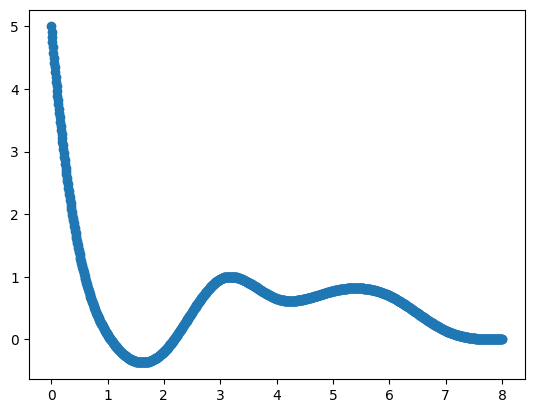

In [21]:
import matplotlib.pyplot as plt
plt.scatter(X, res_scipy);

In [ ]:
def vec_evaluate_spline_new(t, c, k, xp, out):
    if out.shape[0] != xp.shape[0]:
        raise ValueError("out and xp have incompatible shapes")
    # if out.shape[1] != c.shape[1]:
    #     raise ValueError("out and c have incompatible shapes")

    # work: (N, 2k + 2)
    work = torch.empty(xp.shape[0], 2 * k + 2, dtype=torch.float)

    # intervals: (N, )
    intervals = vec_find_intervals(t, xp, k)
    invalid_mask = intervals < 0
    out[invalid_mask, :] = np.nan
    out[~invalid_mask, :] = 0.
    
    if invalid_mask.all():
        return out
    
    work[~invalid_mask] = vectorized_deboor(t, xp[~invalid_mask], k, intervals[~invalid_mask], work[~invalid_mask])
    
    c = c[intervals[~invalid_mask, None] + torch.arange(-k, 1)].squeeze(dim=2)
    out[~invalid_mask, :] = torch.sum(work[~invalid_mask, :k+1] * c, dim=1).unsqueeze(dim=-1)
    return out

In [22]:
import operator
from math import prod

def b_spline(k, t, c, x):
    k = operator.index(k)
    n = t.shape[0] - k - 1

    if k < 0:
        raise ValueError("Spline order cannot be negative.")
    if t.ndim != 1:
        raise ValueError("Knot vector must be one-dimensional.")
    if n < k + 1:
        raise ValueError("Need at least %d knots for degree %d" %
                            (2*k + 2, k))
    if (np.diff(t) < 0).any():
        raise ValueError("Knots must be in a non-decreasing order.")
    if len(np.unique(t[k:n+1])) < 2:
        raise ValueError("Need at least two internal knots.")
    if not np.isfinite(t).all():
        raise ValueError("Knots should not have nans or infs.")
    if c.ndim < 1:
        raise ValueError("Coefficients must be at least 1-dimensional.")
    if c.shape[0] < n:
        raise ValueError("Knots, coefficients and degree are inconsistent.")

    out = torch.empty((len(x), prod(c.shape[1:])), dtype=c.dtype)
    res = torch.nan_to_num(vec_evaluate_spline_new(t, c.reshape(c.shape[0], -1), k, x, out), nan=0)
    return res

In [31]:
k = 2
num_splines = 10
t = torch.linspace(0, 8, num_splines)
t = torch.cat([torch.tensor([t[0] for _ in range(3, 0, -1)]),
                            t,
                            torch.tensor([t[-1] for _ in range(1, 4, 1)])])
n = len(t) - k - 1
c = torch.randn(n)
c[:3] = 5.
c[-5:] = 0.
x = torch.linspace(0, 8, 10)
coef = torch.stack([c for _ in range(len(x))])

# res = b_spline(k, t, coef, x)

In [32]:
import matplotlib.pyplot as plt

plt.scatter(x, res);

NameError: name 'res' is not defined

In [33]:
from scipy.interpolate import BSpline

spl = BSpline(t, coef, k, extrapolate=False)
y = np.nan_to_num(spl(x), nan=0.)

# plt.scatter(x, y);

print(coef.shape, y.shape)

ValueError: Knots, coefficients and degree are inconsistent.